# Benchmark for vibration of a string

Assumptions made:
- string is treated as perfectly flexible (no stiffness)
- fixed-fixed condition so that reflections are perfectly inverted

Goal: simulate the kink resulting from plucking the string

Constituitive equation (wave equation): $\frac{\partial^2 y}{\partial t^2} = c^2 \frac{\partial^2 y}{\partial x^2}$

where,
$
y = displacement\:of\:the\:string\:from\:equilibirum \\
x = position\:along\:the\:string \\
t = time \\
c = \sqrt{\frac{T}{\mu}} = wave\:speed \\
T = tension \\
\mu = mass\:per\:unit\:length \\
$

Citation(s):
$@article\:{giordano1998physics,
  title={The physics of vibrating strings},
  author={Giordano, Nicholas and Gould, Harvey and Tobochnik, Jan}, 
  journal={Computers in Physics}, 
  volume={12},
  number={2}, 
  pages={138--145}, 
  year={1998},
  publisher={American Institute of Physics}
}$

In [61]:
using CombinatorialSpaces
using Catlab.CategoricalAlgebra
using CombinatorialSpaces.DiscreteExteriorCalculus: inv_hodge_star
using DifferentialEquations
using CairoMakie
using Catlab.Graphs
using Catlab.Graphics

# dual subdivision 
function dual(s::EmbeddedDeltaSet1D{O, P}) where {O, P}
  sd = EmbeddedDeltaDualComplex1D{O, eltype(P), P}(s)
  subdivide_duals!(sd, Circumcenter())
  sd
end

dual (generic function with 2 methods)

## Define and plot mesh and boundary conditions

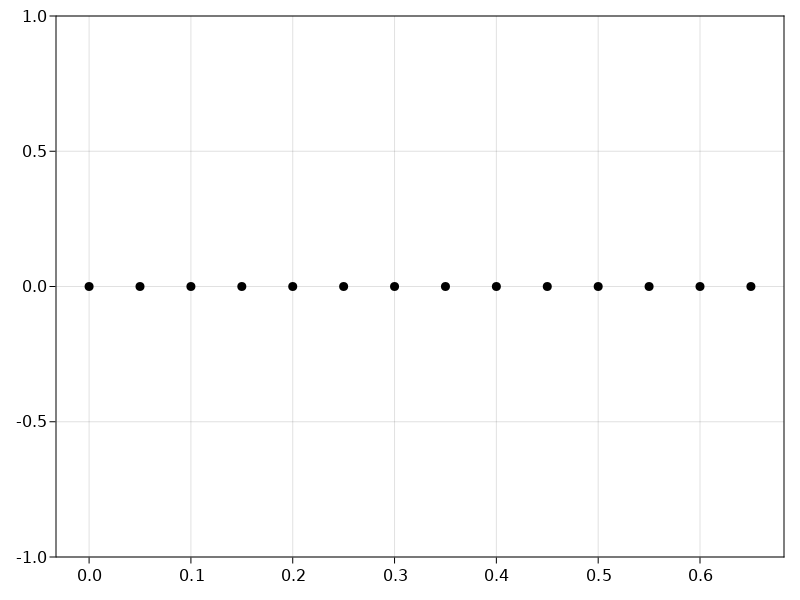

In [70]:
# Define mesh
s2D = EmbeddedDeltaSet2D("meshes/string.obj")
s = EmbeddedDeltaSet1D{Bool, eltype(s2D[:point])}()
copy_parts!(s, s2D)
sd = dual(s)

# Define vertices for BC application (fixed-fixed)
left = 1
right = 13

# Plot mesh
x_loc = [p[1] for p in s[:point]]
y_loc = [p[2] for p in s[:point]]
plot(x_loc, y_loc,
     legend=:none, seriestype = :scatter,
     xlabel="x-coordinate",ylabel="y-coordinate",
     title="Initial String System",
     ylims=[minimum(y_loc),maximum(y_loc)],
     xlims=[minimum(x_loc),maximum(x_loc)], ratio=1)

In [37]:
s
sd

V,vertex_center,point
1,1,"Float32[0.0, 0.0, 0.0]"
2,2,"Float32[0.1, 0.0, 0.0]"
3,3,"Float32[0.15, 0.0, 0.0]"
4,4,"Float32[0.2, 0.0, 0.0]"
5,5,"Float32[0.25, 0.0, 0.0]"
6,6,"Float32[0.3, 0.0, 0.0]"
7,7,"Float32[0.35, 0.0, 0.0]"
8,8,"Float32[0.4, 0.0, 0.0]"
9,9,"Float32[0.45, 0.0, 0.0]"
10,10,"Float32[0.5, 0.0, 0.0]"


## Add the physics

In [36]:
# Define constants
c = 200 # wave speed, m/s

# Define primal forms
x = VForm([p[1] for p in s[:point]]); # x-location along string
# u = EForm([e for e in s)

# Initialize the laplacian operator
lapl = ∇²(Val{0}, sd)

# (-1 * p[1]) * (lapl * u) # laplacian

13×13 SparseArrays.SparseMatrixCSC{Float64, Int64} with 37 stored entries:
 NaN    NaN       ⋅      ⋅      ⋅   …     ⋅      ⋅      ⋅      ⋅      ⋅ 
 NaN    NaN    NaN       ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅   NaN    NaN    NaN       ⋅         ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅   NaN    NaN    NaN          ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅   NaN    NaN          ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅   NaN    …     ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      NaN       ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      NaN    NaN       ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      NaN    NaN    NaN       ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅   …     ⋅   NaN    NaN    NaN       ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅   NaN    NaN    NaN
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅ 

## Initialize the simulation

In [ ]:
# Initialize physics sim
vf(du, u, p, t) = begin
  du .= (-1 * p[1]) * (lapl * u)
  du[boundary_v] .= 0.0
end